# Install Data

In [1]:
# !rm -rf /content/Forehead_Filted.zip
# !rm -rf /content/Forehead_Filted
# !gdown -q 1VqbIYbwpcyitFDH3OJ_mgzyA-tKUZ-ks
# !unzip -q /content/Forehead_Filted.zip


# Install Library

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from datetime import datetime
from glob import glob
import imageio
from tempfile import TemporaryDirectory
# cudnn.benchmark = True
plt.ion()   # interactive mode

# Preprocessing

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
batch_size = 64
train_dataset = datasets.ImageFolder(
    '/content/Forehead_Filted/train',
    transform = train_transform
)
test_dataset = datasets.ImageFolder(
    '/content/Forehead_Filted/val',
    transform = test_transform
)

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle =True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle =False
)

In [6]:
# Class torchvision.datasets.ImageFolder
if hasattr(train_dataset, 'classes'):
    print("Class labels:", train_dataset.classes)
else:
    print("Class labels not found.")

if hasattr(test_dataset, 'classes'):
    print("Class labels:", test_dataset.classes)
else:
    print("Class labels not found.")


Class labels: ['cAverage', 'cFair', 'cGood']
Class labels: ['cAverage', 'cFair', 'cGood']


In [7]:
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 


## In ra kiến trức model mobilev2

In [8]:
# print(model)

In [9]:
# lớp phân loại của mobilenetv2
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
n_class = 3
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.4),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.7),
    nn.Linear(num_ftrs,n_class)
)

In [11]:
# lớp phân loại sau khi sửa và thêm các lớp cuối
model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=1280, bias=True)
  (1): Dropout(p=0.3, inplace=False)
  (2): Linear(in_features=1280, out_features=1280, bias=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=1280, out_features=1280, bias=True)
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1280, out_features=3, bias=True)
)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# Loss and optimizer
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Tạo thư mục chứa weight

In [14]:
folder_path = "output"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f'Thư mục "{folder_path}" đã được tạo.')
else:
    print(f'Thư mục "{folder_path}" đã tồn tại.')


Thư mục "output" đã được tạo.


# Training

In [15]:
def batch_gd(model, criteration, optimizer, train_loader, test_loader, epoch):
  train_losses = np.zeros(epoch)
  train_accs = np.zeros(epoch)
  test_losses = np.zeros(epoch)
  test_accs = np.zeros(epoch)
  best_acc = 0.0
  best_model_params_path = os.path.join(folder_path, 'MobileNetV2_best.pt')
  last_model_params_path = os.path.join(folder_path, 'MobileNetV2_last.pt')
  for it in range(epoch):
    print(f"Epoch {it+1}/{epoch}")
    print('-' * 10)
    model.train()
    t0 = datetime.now()
    train_loss = []
    n_correct = 0
    n_total = 0
    train_acc = 0
    # Get train_acc and train_loss
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      #forward pass
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      # Backward
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_acc = n_correct/n_total

    # Save loss and test
    train_losses[it] = train_loss
    train_accs[it] = train_acc

    #Get test loss and test acc
    model.eval()
    test_loss = []
    n_correct = 0
    n_total = 0
    test_acc = 0.0
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    test_acc = n_correct/n_total
    # get best accuracy
    if best_acc < test_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), best_model_params_path)
    # Save Loss
    test_losses[it] = test_loss
    test_accs[it] = test_acc

    dt = datetime.now() - t0
    print(f'Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} \nTest Acc: {test_acc:.4f},Loss:{test_loss:.4f} \nDuration {dt}\n')
    if it == epoch -1:
      print("\n----------------------\n")
      print(f"Best Accuracy: {best_acc:.4f}")
      torch.save(model.state_dict(), last_model_params_path)
  return train_losses, test_losses,train_accs,test_accs

In [16]:
epochs = 20
train_losses, test_losses, train_acc, test_acc = batch_gd(
    model,
    criteration,
    optimizer,
    train_loader,
    test_loader,
    epochs
)

Epoch 1/20
----------
Train Acc: 0.3538, Loss: 1.0995 
Test Acc: 0.5087,Loss:1.0659 
Duration 0:00:18.120411

Epoch 2/20
----------
Train Acc: 0.4539, Loss: 1.0557 
Test Acc: 0.5954,Loss:1.0278 
Duration 0:00:19.071249

Epoch 3/20
----------
Train Acc: 0.5666, Loss: 0.9723 
Test Acc: 0.6590,Loss:0.9193 
Duration 0:00:15.606655

Epoch 4/20
----------
Train Acc: 0.6588, Loss: 0.8089 
Test Acc: 0.7225,Loss:0.7270 
Duration 0:00:14.191721

Epoch 5/20
----------
Train Acc: 0.7321, Loss: 0.6284 
Test Acc: 0.6301,Loss:0.7059 
Duration 0:00:16.126050

Epoch 6/20
----------
Train Acc: 0.7644, Loss: 0.5300 
Test Acc: 0.7746,Loss:0.5586 
Duration 0:00:21.664619

Epoch 7/20
----------
Train Acc: 0.7778, Loss: 0.4900 
Test Acc: 0.7919,Loss:0.4988 
Duration 0:00:23.767707

Epoch 8/20
----------
Train Acc: 0.8148, Loss: 0.4287 
Test Acc: 0.7688,Loss:0.5167 
Duration 0:00:14.359641

Epoch 9/20
----------
Train Acc: 0.8156, Loss: 0.4142 
Test Acc: 0.6879,Loss:0.6443 
Duration 0:00:15.025471

Epoch 10/2

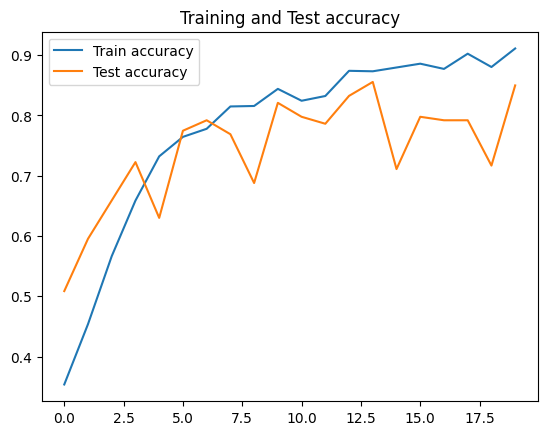

In [17]:
#plot train loss and test loss
plt.plot(train_acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.title("Training and Test accuracy")
plt.legend()
plt.show()

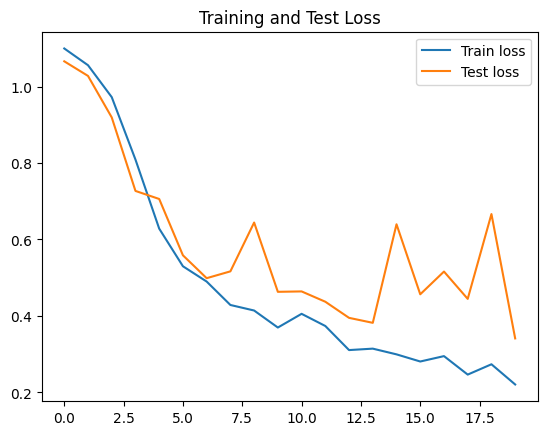

In [18]:
#plot train loss and test loss
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

In [19]:

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

In [20]:
train_acc

0.900709219858156

In [21]:
#plot confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,title = "confusion matrix",cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
  else:
    print("Confusion maxtrix, without normalization")
  print(cm)

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks,classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center", color = 'white' if cm[i,j]> thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Prediction")
  plt.show()


Confusion maxtrix, without normalization
[[41  1 10]
 [ 8 45  0]
 [ 7  0 61]]


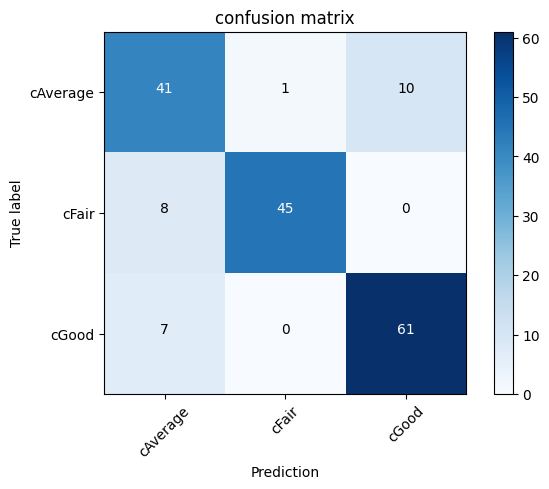

In [22]:
# get all prediction in an array and plot confusion matrix
x_test = test_dataset.imgs
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
x = list(train_dataset.classes)
plot_confusion_matrix(cm, x)

# Load best model

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [24]:
model.load_state_dict(torch.load('/content/output/MobileNetV2_best.pt'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [28]:
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc_best = n_correct/n_total
print(test_acc_best)

0.8554913294797688


In [26]:

from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits = 4)
    return report

# Sử dụng hàm evaluate_model để đánh giá mô hình trên tập kiểm thử
test_report = evaluate_model(model, test_loader, device)#val, test
print(test_report)

              precision    recall  f1-score   support

    cAverage     0.7213    0.8462    0.7788        52
       cFair     1.0000    0.8491    0.9184        53
       cGood     0.8806    0.8676    0.8741        68

    accuracy                         0.8555       173
   macro avg     0.8673    0.8543    0.8571       173
weighted avg     0.8693    0.8555    0.8590       173



Confusion maxtrix, without normalization
[[44  0  8]
 [ 8 45  0]
 [ 9  0 59]]


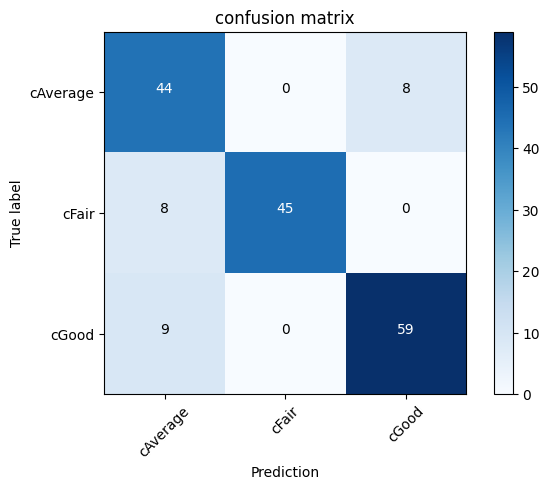

In [29]:
# get all prediction in an array and plot confusion matrix
x_test = test_dataset.imgs
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
x = list(train_dataset.classes)
plot_confusion_matrix(cm, x)